In [1]:
import tensorflow
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2

In [2]:
def image_display(image,title=''):
#     fig = plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(image, cmap='Greys_r')
    plt.show()
    
def side2side_plotter(images):
    # Plot the result
    number_of_plots = len(images)
    if number_of_plots>1:
        fig , (ax)= plt.subplots(1, number_of_plots, figsize=(10, 9))
        fig.tight_layout()
        for i in range(number_of_plots):
            ax[i].imshow(images[i][0],cmap='Greys_r')
            ax[i].set_title(images[i][1])
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    elif number_of_plots==1:
        fig, ax= plt.subplots(1, 1, figsize=(5, 5)) 
        ax.imshow(images[0][0],cmap='Greys_r')
        ax.set_title(images[0][1])
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [3]:
# 1- calibrating camera

camera_images = glob.glob('camera_cal/*') 
print('Images available for calibrating camera: {}'.format(len(camera_images)))

#calibration rows/cols
nx = 9
ny = 6

#creating images_points and object_points list for calibrating camera
image_points = []
object_points = []

default_obj_point = np.zeros((ny*nx,3), np.float32)
default_obj_point[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

print('Wroking ...')
failed_corners = []
success_corners = []
for i , img in enumerate(camera_images):
    #read image
    im = mpimage.imread(img)
    #gray scale
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    #get corners
    ret, corners =  cv2.findChessboardCorners(gray_im, (nx,ny))
    if ret is True:
        image_points.append(corners)
        object_points.append(default_obj_point)
        cv2.drawChessboardCorners(im, (nx,ny), corners, ret)
        success_corners.append((im,img))
    else:
        failed_corners.append((i,img))
print('Finished collecting points')

Images available for calibrating camera: 20
Wroking ...
Finished collecting points


Detected corners:


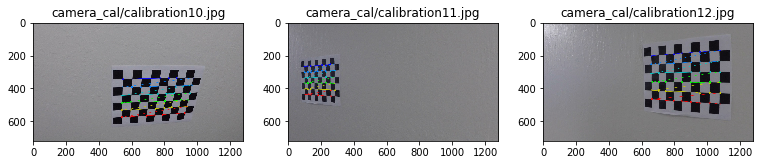

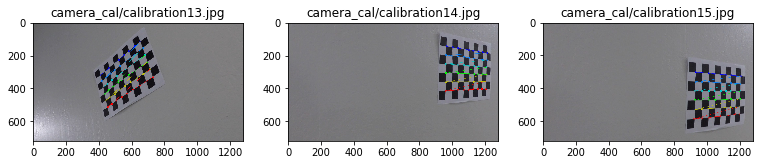

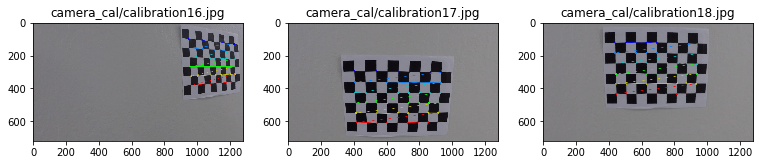

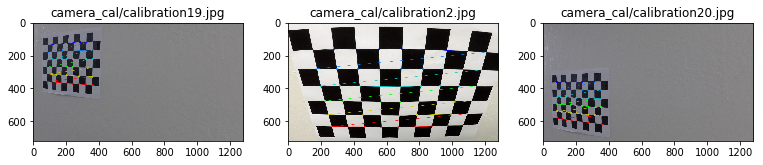

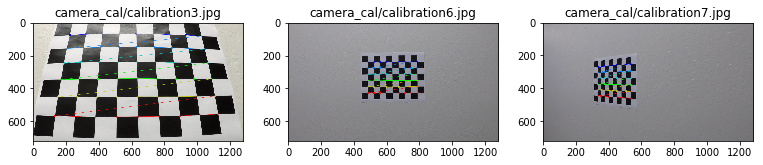

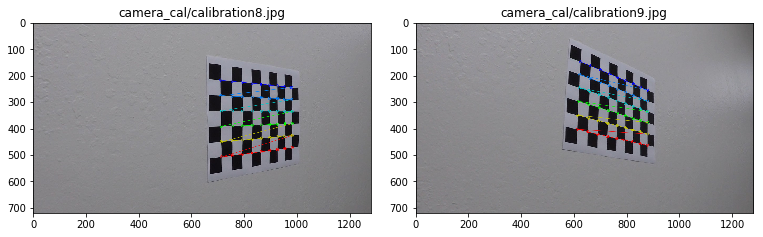

Failed on finding corners for the following images:
image #0, path: camera_cal/calibration1.jpg
image #14, path: camera_cal/calibration4.jpg
image #15, path: camera_cal/calibration5.jpg


In [4]:
print('Detected corners:')

for i in range(0,len(success_corners),3):
    display_images=[]
    im1= success_corners[i][0]
    display_images.append([im1,"{}".format(success_corners[i][1])])
    if (i+1) < len(success_corners):
        im2= success_corners[i+1][0]
        display_images.append([im2,"{}".format(success_corners[i+1][1])])
        if (i+2) < len(success_corners):
            im3= success_corners[i+2][0]
            display_images.append([im3,"{}".format(success_corners[i+2][1])])
    side2side_plotter(display_images)
    
print('Failed on finding corners for the following images:')
for i,im in failed_corners:
    print('image #{}, path: {}'.format(i,im))

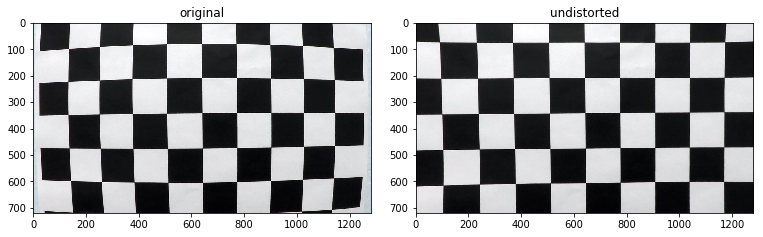

In [5]:
# step 2
def undistort(img):
    img_copy = np.copy(img)
    img_size=(img.shape[1],img_copy.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera( object_points, image_points, img_size,None,None)
    undistort_image = cv2.undistort(img_copy, mtx, dist, None, mtx)
    return undistort_image

# testing calibrate and undistort on an image that was not used in 
img = cv2.imread('camera_cal/calibration1.jpg')
undistort_image = undistort(img)
u_images = [[img,'original'], [undistort_image,'undistorted']]
side2side_plotter(u_images)

In [6]:
# Finding gradient binary
def gradient_binary(img, thresh=[90,200],orientation='x', ksize=3):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orientation=='y':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F,0,1, ksize=ksize)
    else:
        sobel = cv2.Sobel(gray_img, cv2.CV_64F,1,0, ksize=ksize)
    sobel_abs = np.absolute(sobel)
    sobel_scaled= np.uint8(255* sobel_abs/np.max(sobel_abs))
    sobel_binary = np.zeros_like(sobel_scaled)
    sobel_binary[(sobel_scaled>thresh[0])&(sobel_scaled<=thresh[1])]=1
    return sobel_binary

In [7]:
# converting image to HLS channel

def hls_binary(img, thresh=[90,200], channel='s'):
    hls_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS).astype(np.float)
    if channel =='h':
        hls_img = hls_img[:,:,0]
    elif channel == 'l':
        hls_img = hls_img[:,:,1]
    else:
        hls_img = hls_img[:,:,2]
    hls_binary= np.zeros_like(hls_img)
    hls_binary[(hls_img>thresh[0])&(hls_img<=thresh[1])]=1
    return hls_binary

In [8]:
def rgb_binary(img, thresh=[90,200], channel='r'):
    copy_img = np.copy(img)
    if channel =='r':
        copy_img = copy_img[:,:,0]
    elif channel == 'g':
        copy_img = copy_img[:,:,1]
    else:
        copy_img = copy_img[:,:,2]
    rgb_binary= np.zeros_like(copy_img)
    rgb_binary[(copy_img>thresh[0])&(copy_img<=thresh[1])]=1
    return rgb_binary

In [9]:
#step 3
def combine_binaries(binary_img1, binary_img2, return_color_combination=False):
    color_combination=[]
    if return_color_combination is True:
        color_combination = np.dstack((np.zeros_like(binary_img1), binary_img1, binary_img2))
    binary = np.zeros_like(binary_img1)
    binary[(binary_img1==1)|(binary_img2==1)]=1
    return binary, color_combination

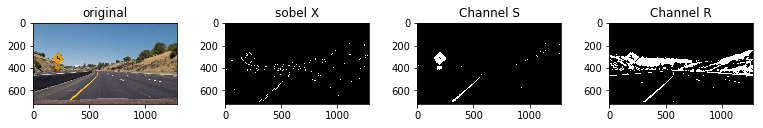

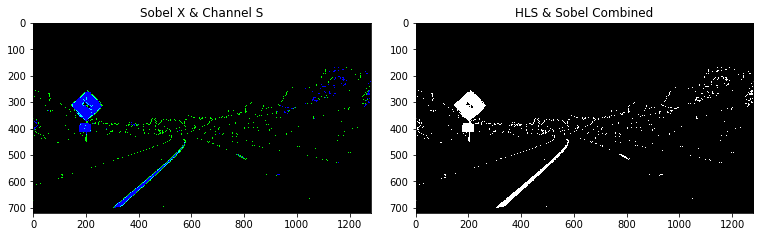

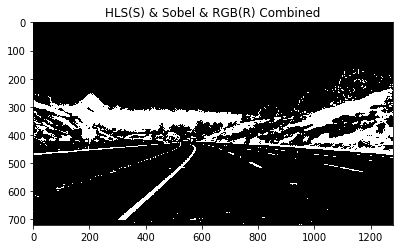

In [10]:
# #testing sobel & hls
test_img = mpimage.imread('test_images/test2.jpg')
undistort_image = undistort(test_img)
sobel_img = gradient_binary(undistort_image, thresh=[50,150])
hls_img = hls_binary(undistort_image, thresh=[150,255])
rgb_img = rgb_binary(undistort_image, thresh=[150,255])
side2side_plotter([[test_img,'original'],[sobel_img,'sobel X'],[hls_img,'Channel S'],[rgb_img,'Channel R']])
combined_binary, color_combination = combine_binaries(sobel_img, hls_img, True)
combined_binary2, color_combination2 = combine_binaries(combined_binary, rgb_img, False)
side2side_plotter([[color_combination,'Sobel X & Channel S'],[combined_binary,'HLS & Sobel Combined']])
side2side_plotter([[combined_binary2,'HLS(S) & Sobel & RGB(R) Combined']])


In [11]:
#step 4
def get_perspective_transformation(img, src_vertices, dst_vertices):
    src =np.float32(src_vertices)
    dst=np.float32(dst_vertices)
    M = cv2.getPerspectiveTransform(src,dst)
    warped_image = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    return warped_image, M

In [12]:
# region of interest
def display_region(original_img , gray_img, src_vertices):
    img_copy = np.copy(original_img)
    pts = np.array(src_vertices, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img_copy,[pts],True,(255,0,0), thickness=3)
    return img_copy


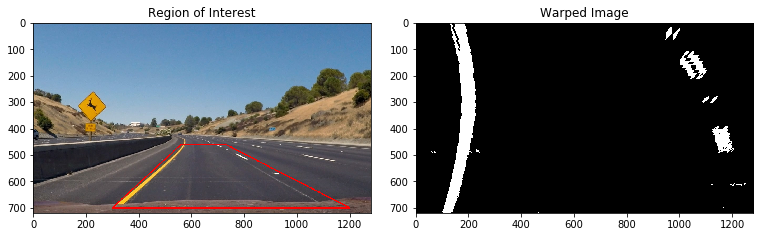

In [13]:

# test region & warp
test_img = mpimage.imread('test_images/test2.jpg')
img_size = [combined_binary.shape[0],combined_binary.shape[1]]
src_vertices =[[560,460],[730,460],[1200,700],[300,700]]
offset = 100
dst_vertices = [[offset,offset],[img_size[1]-1,offset],[img_size[1]-1,img_size[0]-1],[offset,img_size[0]-1]]
    
img_region = display_region(test_img,combined_binary,src_vertices)
warped_img, M = get_perspective_transformation(combined_binary,src_vertices,dst_vertices)
side2side_plotter([[img_region,'Region of Interest'],[warped_img,'Warped Image']])


In [14]:
# step 5
# histogram | convolve

def reject_outliers(datax,datay, m=2):
    indicies= np.where(abs(datax - np.mean(datax)) < m * np.std(datax))[0]
    outputx= datax[indicies]
    outputy= datay[indicies]
    return outputx,outputy

def sliding_window_histogram(img, n_windows=9):
    try:
        good_left = []
        good_right = []
        img_output = np.dstack((img, img, img))*255
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
#         plt.plot(histogram)
#         plt.show()
        window_height = int(img.shape[0]/n_windows)
        #find halves
        midpoint= int(histogram.shape[0]/2)
        left_half = histogram[0:midpoint]
        right_half = histogram[midpoint:]

        #find nonzeros
        nonzero = img.nonzero()
        nonzero_x = np.array(nonzero[1])
        nonzero_y = np.array(nonzero[0])

        #get the base
        left_base = np.argmax(left_half, axis=0)
        right_base = np.argmax(right_half, axis=0)+midpoint

        left_current = left_base
        right_current = right_base

        max_pix = 300
        number_nonzeros = 500
        margin = 150
        left_margin  =150
        last_good_points_left = np.array([])
        last_good_points_right = np.array([])
        for i in range(n_windows):
            
            y_high = img.shape[0] - i*window_height
            y_low = img.shape[0] - (i+1)*window_height

            x_left_low = left_current-left_margin
            x_left_high = left_current+margin

            x_right_low = right_current-margin
            x_right_high = right_current+margin

            cv2.rectangle(img_output, (x_left_low, y_low) ,(x_left_high, y_high), (0,255,0),2)
            cv2.rectangle(img_output, (x_right_low, y_low) ,(x_right_high, y_high), (0,255,0),2)

            good_left_indexes = ((nonzero_x>x_left_low)&(nonzero_x<x_left_high)&(nonzero_y>y_low)&(nonzero_y<y_high)).nonzero()[0]
            good_right_indexes = ((nonzero_x>x_right_low)&(nonzero_x<x_right_high)&(nonzero_y>y_low)&(nonzero_y<y_high)).nonzero()[0]

            good_left.append(good_left_indexes)
            good_right.append(good_right_indexes)
            if len(good_left_indexes)>= max_pix :
                left_current= np.int(np.mean(nonzero_x[good_left_indexes]))
            if len(good_right_indexes)>= max_pix:
                right_current= np.int(np.mean(nonzero_x[good_right_indexes]))
                
        '''
        Concatenate the arrays of indices & Extract left and right line pixel positions 
        '''
        left_lane_inds = np.concatenate(good_left)
        right_lane_inds = np.concatenate(good_right)

        leftx = nonzero_x[left_lane_inds]
        lefty = nonzero_y[left_lane_inds] 
        rightx = nonzero_x[right_lane_inds]
        righty = nonzero_y[right_lane_inds] 
       
        ''' 
        Fit a second order polynomial for left and right line
        '''
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        try:
            leftx, lefty= reject_outliers(leftx,lefty)
            left_fit = np.polyfit(lefty, leftx, 2)
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        except Exception as err:
            left_fitx=None
            left_fit=None

        try:
            rightx, righty= reject_outliers(rightx,righty)
            right_fit = np.polyfit(righty, rightx, 2)
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except Exception as err:
            right_fitx = None
            right_fit = None

        img_output[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
        img_output[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

        left_line = {'x':leftx, 'y':lefty, 'fitx':left_fitx, 'coefficient':left_fit, 'slope':0}
        right_line = {'x':rightx, 'y':righty, 'fitx':right_fitx, 'coefficient':right_fit, 'slope':0}

    except Exception as err:
        print(err)
    return img_output, left_line, right_line, ploty


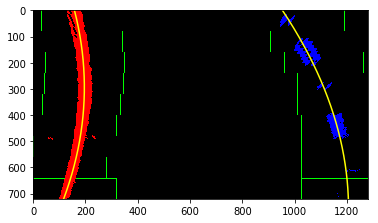

In [15]:
output_img, left_line, right_line, ploty = sliding_window_histogram(warped_img)
plt.imshow(output_img)
if left_line['fitx'] is not None:
    plt.plot(left_line['fitx'], ploty, color='yellow')
if right_line['fitx'] is not None:
    plt.plot(right_line['fitx'], ploty, color='yellow')
plt.xlim(0, warped_img.shape[1])
plt.ylim(warped_img.shape[0], 0)
plt.show()

In [16]:
def calculate_curve_slope_distance(warped_img, lines, ploty):
    lines['left']['curve']= 0
    lines['right']['curve']= 0
    car_position = (warped_img.shape[1]/2)
    ym_per_pix = 30/warped_img.shape[0]# meters per pixel in y dimension
    xm_per_pix = 3.7/warped_img.shape[1]/2 # meters per pixel in x dimension
    meter_per_pixel={'x':xm_per_pix,'y':ym_per_pix}
    
    try:
        center_x_point= int(warped_img.shape[1]/2)
        y_eval = np.max(ploty)
        # Fit new polynomials to x,y in world space
        fit_cr_left = np.polyfit(lines['left']['y']*ym_per_pix, lines['left']['x']*xm_per_pix, 2)
        fit_cr_right = np.polyfit(lines['right']['y']*ym_per_pix, lines['right']['x']*xm_per_pix, 2)

        # Calculate the new radii of curvature
        curve_left = ((1 + (2*fit_cr_left[0]*y_eval*ym_per_pix + fit_cr_left[1])**2)**1.5) / np.absolute(2*fit_cr_left[0])
        curve_right = ((1 + (2*fit_cr_right[0]*y_eval*ym_per_pix + fit_cr_right[1])**2)**1.5) / np.absolute(2*fit_cr_right[0])
        lines['left']['curve']= curve_left
        lines['right']['curve']= curve_right
        center_of_image = int(warped_img.shape[1]/2)
        car_position = (((lines['right']['x'][0]+ lines['left']['x'][0])/2) -center_of_image) * xm_per_pix
    except Exception as err:
        print(err)
        pass
    finally:
        lines['distance'] = car_position
    return lines,meter_per_pixel 

In [17]:
# Create an image to draw the lines on
import math

flags = {'slope':False, 'distance':False, 'expected':False, 'curve':False}
def project_lines_to_road(img_resources, lines, meter_per_pixel, M):
    
    original_img = img_resources['original']
    warped_img = img_resources['warped']
    undistort_img = img_resources['undistorted']
    left_line = lines['left']
    right_line = lines['right']
    ploty = lines['ploty']
    curve= (lines['left']['curve'] + lines['right']['curve'])/2
    car_position = lines['distance']
    
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ''' 
    Recast the x and y points into usable format for cv2.fillPoly()
    '''
    pts_left = np.array([np.transpose(np.vstack([left_line['fitx'], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line['fitx'], ploty])))])
    pts = np.hstack((pts_left, pts_right))

    '''
    Draw the lane onto the warped blank image
    '''
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    
    '''
    Warp the blank back to original image space using inverse perspective matrix (Minv)
    and combine the result with the original image
    '''
    Minv = np.linalg.inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'curve_avg: {0:.2f}m'.format(curve),(850,50), font, 1,(255,255,255),2) 
    cv2.putText(result,'distance_center: {0:.2f}m '.format(car_position),(850,100), font, 1,(255,255,255),2)
    
    return result


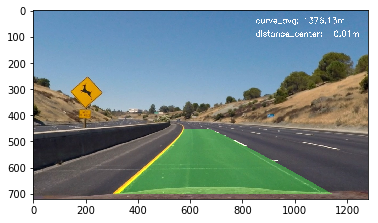

In [18]:
#test 
image_res = {'original':test_img,'warped':warped_img,'undistorted':undistort_image}
lines= {'left':left_line,'right':right_line, 'ploty':ploty}
lines,meter_per_pixel = calculate_curve_slope_distance(warped_img, lines, ploty)
output_img = project_lines_to_road(image_res, lines, meter_per_pixel,M)
image_display(output_img)

In [19]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #avg distance
        self.avg_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.coefficients = None
        self.line =None
        

    def populate(self,new_line,all_instances,meter_per_pixel):
        try:
            if new_line['fitx'] is not None and new_line['coefficient'] is not None:
                self.detected = True 
                self.current_fit = new_line['coefficient']
                self.radius_of_curvature = new_line['curve']
                self.line_base_pos = new_line['x'][0]*meter_per_pixel['x']
                self.allx = new_line['x']
                self.ally = new_line['y']

                if len(all_instances) > 0:
                    self.diffs = all_instances[-1].current_fit - self.current_fit
                    self.recent_xfitted = all_instances[-1].allx
                    self.bestx = (new_line['fitx']+all_instances[-1].bestx*len(all_instances))/(len(all_instances)+1)
                    self.best_fit = self.current_fit
                else:
                    self.recent_xfitted = new_line['fitx']
                    self.bestx =  new_line['fitx']
                    self.best_fit = new_line['coefficient']
                    self.diffs = None
                    self.current_fit = new_line['coefficient']
        except Exception as err:
            print(err)
        

In [20]:
'''
calculates slope using 1st order derivative of line
'''    
def find_slope(coefficients, height):
    y_mid = height/2
    slope = 2*coefficients[0]*y_mid + coefficients[1]*y_mid
    return slope
    
'''
Gamma correction to fix illumination or shadows
''' 
def adjust_gamma(image, gamma=1.0):
    ''' 
    build a lookup table mapping the pixel values [0, 255] to
    their adjusted gamma values
    '''
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)    

def evaluate(warped_img,combined_binary,dst_vertices,new_lines, new_instances,all_instances , distance_offset_meter = 0.5, slope_offset=2, curve_offset =1000):
    global count_bad_frames 
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    right_needs_fix = False
    left_needs_fix = False
    try:
        good_match = False
        if len(all_instances['left']) >0 and len(all_instances['right'])>0 :
            
            # 1- is line detected?
            if new_instances['left'].detected is True and new_instances['right'].detected is True:
                good_match = True     
            '''
            2- check expected x value
            find indices of the top of the image [0,~300] for left & right
            calculate the mean position of x,y for left and right
            calculate expected x value for such y using previous left_fitx & right_fitx 
            '''
            half_img = int(warped_img.shape[0]/2)
            indices_left =np.where(new_lines['left']['y']<=half_img )            
            current_y_left = np.mean(new_lines['left']['y'][indices_left])
            current_x_left = np.mean(new_lines['left']['x'][indices_left])

            expected_x_left = all_instances['left'][-1].current_fit[0]* current_y_left**2 \
                            + all_instances['left'][-1].current_fit[1]*current_y_left + all_instances['left'][-1].current_fit[2]
            
            indices_right =np.where(new_lines['right']['y']<=half_img )            
            current_y_right = np.mean(new_lines['right']['y'][indices_right])
            current_x_right = np.mean(new_lines['right']['x'][indices_right])

            expected_x_right = all_instances['right'][-1].current_fit[0]* current_y_right**2 \
                            + all_instances['right'][-1].current_fit[1]*current_y_right + all_instances['right'][-1].current_fit[2]
             
            '''
            3- check expected slope value
            find slope of left & right fit using 1st derivatives of current left, right fits
            find slope of left & right fit using 1st derivatives of previous fit
            '''
            current_left_slope = find_slope(new_instances['left'].current_fit, warped_img.shape[0])
            expected_left_slope= find_slope(all_instances['left'][0].current_fit, warped_img.shape[0])
            current_right_slope = find_slope(new_instances['right'].current_fit, warped_img.shape[0])
            expected_right_slope = find_slope(all_instances['right'][0].current_fit, warped_img.shape[0])
            

            '''
            4- check expected Vs current values for both left and right and set theri flags
            '''
            if abs(expected_left_slope - current_left_slope)>10 or abs(expected_x_left - current_x_left)>15 :
                good_match =False
                left_needs_fix = True
        
            if abs(expected_right_slope - current_right_slope)>10 or abs(expected_x_right - current_x_right)>15 :
                good_match =False
                right_needs_fix = True
                             
        
        #First entry, empty cache
        else:
            if new_instances['left'].detected and new_instances['right'].detected :
                good_match = True
                
        '''
        check cached lines
        if its not a good match do left or right fix by copying previous instances from the cache
        and increment count_bad_frames
        '''
        if len(all_instances['left']) >0 and len(all_instances['right']) >0:
            if good_match is False:
                if left_needs_fix is True:
                    new_instances['left']= all_instances['left'][-1]
                    new_lines['left']['fitx'] = all_instances['left'][-1].current_fit[0]*ploty**2 + all_instances['left'][-1].current_fit[1]*ploty + all_instances['left'][-1].current_fit[2]
                    new_lines['left']['x'] = all_instances['left'][-1].allx
                    new_lines['left']['y'] = all_instances['left'][-1].ally
                    new_lines['left']['coefficients'] =  all_instances['right'][-1].current_fit
                if right_needs_fix is True:
                    new_instances['right']= all_instances['right'][-1]
                    new_lines['right']['fitx'] = all_instances['right'][-1].current_fit[0]*ploty**2 + all_instances['right'][-1].current_fit[1]*ploty + all_instances['right'][-1].current_fit[2]
                    new_lines['right']['x'] = all_instances['right'][-1].allx
                    new_lines['right']['y'] = all_instances['right'][-1].ally
                    new_lines['right']['coefficients'] =  all_instances['right'][-1].current_fit
                    flags['right']='fixed'

                count_bad_frames +=1
            else:
                #reset counter, this frame is good !
                count_bad_frames =0
        else:
            #reset counter, this frame is good !
            count_bad_frames =0
        '''
        append frame to cached instance
        '''
        all_instances['left'].append(new_instances['left'])
        all_instances['right'].append(new_instances['right'])
    except Exception as err:
        print(err)
        pass
    return all_instances, new_lines, flags, count_bad_frames

In [21]:
# # Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(image):
    global all_instances
    global src_vertices
    global offset
    global count_bad_frames
    global fram_counter
    global old_white_ratio
    global white_ratio_increasing
    
    global make_darker
    global rgb_channel
    global make_brighter
    
    output_image= np.copy(image)
    
    undistort_img = undistort(image)
    
    if make_darker is True:
        undistort_img = adjust_gamma(undistort_img, gamma=0.5)
        
#     image_display(undistort_img, 'undistort')
    sobel_img = gradient_binary(undistort_img, thresh=[50,150])
    hls_img = hls_binary(undistort_img, thresh=[100,255])
    combined_binary, color_combination = combine_binaries(sobel_img, hls_img, True)
    '''
        if need combining with rgb channel
    '''
    if rgb_channel:
        rgb_img = rgb_binary(undistort_img, thresh=[150,255])
        combined_binary, color_combination = combine_binaries(combined_binary, rgb_img, True)


#     image_display(combined_binary)
    img_size = [combined_binary.shape[0],combined_binary.shape[1]]       
    
    dst_vertices = [[offset,offset],[img_size[1]-offset,offset],[img_size[1]-offset,img_size[0]-offset],[offset,img_size[0]-offset]]
    img_region = display_region(image,combined_binary,src_vertices)

    
    img_size = [combined_binary.shape[0],combined_binary.shape[1]]       
    warped_img, M = get_perspective_transformation(combined_binary,src_vertices,dst_vertices)      

    '''
    is white range increasing? I use it to look for upcoming very bright areas with high illumination 
    '''
    warped_img_copy = np.copy(warped_img)
    total_pix = warped_img_copy.shape[0]*warped_img_copy.shape[1]
    total_white = cv2.countNonZero(warped_img_copy)
    white_ratio = int((total_white/total_pix)*100)
    
    output_img = np.copy(undistort_img)
    if old_white_ratio < white_ratio:
        white_ratio_increasing = True
        old_white_ratio = white_ratio
    else:
        white_ratio_increasing = False
        old_white_ratio = white_ratio
     
    '''
    if need to make image brighter to detect light pavement illumination:
    apply gamma_correction 1.5 & look for white ratio higher than 4 
    ''' 
    if white_ratio>4 and make_brighter is True:
        gamma_fix = adjust_gamma(undistort_img, gamma=1.5)
        sobel_img = gradient_binary(gamma_fix, thresh=[50,150])
        hls_img = hls_binary(gamma_fix, thresh=[100,255])
        combined_binary, color_combination = combine_binaries(sobel_img, hls_img, True)
#         image_display(combined_binary,'Gamma Correction')
    

    warped_img, M = get_perspective_transformation(combined_binary,src_vertices,dst_vertices)

    output_img, left_line, right_line, ploty = sliding_window_histogram(warped_img)
    new_lines = {'left':left_line, 'right':right_line, 'ploty':ploty}
    
    
    
    new_lines, meter_per_pixel = calculate_curve_slope_distance(warped_img, new_lines, ploty)
    image_resources = {'original':image, 'warped':warped_img, 'undistorted':undistort_img}
    left_instance = Line()
    left_instance.populate(new_lines['left'],all_instances['left'], meter_per_pixel) 
    right_instance = Line()
    right_instance.populate(new_lines['right'],all_instances['right'], meter_per_pixel) 
    new_instances = {'left': left_instance, 'right':right_instance}
    
    all_instances,new_lines, flags, count_bad_frames = evaluate(warped_img,combined_binary,dst_vertices, new_lines, new_instances, all_instances)

#     plt.imshow(output_img)
#     if left_line['fitx'] is not None:
#         plt.plot(left_line['fitx'], ploty, color='yellow')
#     if right_line['fitx'] is not None:
#         plt.plot(right_line['fitx'], ploty, color='yellow')
#     plt.xlim(0, warped_img.shape[1])
#     plt.ylim(warped_img.shape[0], 0)
#     plt.show()
    output_image = project_lines_to_road(image_resources,new_lines , meter_per_pixel,M)
    font = cv2.FONT_HERSHEY_SIMPLEX

#     image_display(output_image)
    #reset
    if white_ratio_increasing is False and white_ratio<6 and count_bad_frames>3:
        all_instances = {'left':[],'right':[]}
        count_bad_frames = 0
    return output_image

In [22]:
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML


# def process_image(image):
#     global all_instances
#     global src_vertices
#     global offset
#     global count_bad_frames
#     global old_white_ratio
#     global white_ratio_increasing
#     global make_darker
#     global rgb_channel
#     global make_brighter
#     global bad_frame_limit
    
#     output_image= np.copy(image)
# #     image_display(image,'original')

#     '''
#     Undistort the image
#     '''
#     undistort_img = undistort(image)
# #     image_display(undistort_img, 'undistorted')
    
#     img_size = [undistort_img.shape[0],undistort_img.shape[1]]  
    
#     '''
#     if need to make image darker, apply gamma_correction 0.5 to change illumination
#     ''' 
#     if make_darker:
#         undistort_img = adjust_gamma(undistort_img, gamma=0.5)
        
#     '''
#     Combining binary color channels and sobel x
#     '''
#     sobel_img = gradient_binary(undistort_img, thresh=[50,150])
#     hls_img = hls_binary(undistort_img, thresh=[100,255])
#     combined_binary, color_combination = combine_binaries(sobel_img, hls_img, True)

#     '''
#     if need combining with rgb channel
#     '''
#     if rgb_channel:
#         rgb_img = rgb_binary(undistort_img, thresh=[150,255])
#         combined_binary, color_combination = combine_binaries(combined_binary, rgb_img, True)

# #     image_display(combined_binary)
         
    
#     dst_vertices = [[offset,offset],[img_size[1]-offset,offset],[img_size[1]-offset,img_size[0]-offset],[offset,img_size[0]-offset]]
#     img_region = display_region(image,combined_binary,src_vertices)
    
#     img_size = [combined_binary.shape[0],combined_binary.shape[1]]       

    
#     '''
#     calculating white ratio in binary combination. 
#     For average to perfect frames (no illumination or shadow) white ratio remains in 3-4% range
#     '''
#     total_pix = img_size[0]*img_size[1]
#     total_white = cv2.countNonZero(combined_binary)
#     white_ratio = int((total_white/total_pix)*100)
    
#     '''
#     is white range increasing? I use it to look for upcoming very bright areas with high illumination 
#     '''
#     if old_white_ratio < white_ratio:
#         white_ratio_increasing = True
#         old_white_ratio = white_ratio
#     else:
#         white_ratio_increasing = False
#         old_white_ratio = white_ratio
        
#     '''
#     if need to make image brighter to detect light pavement illumination:
#     apply gamma_correction 1.5 & look for white ratio higher than 4 
#     ''' 
#     if white_ratio>4 and make_brighter:
#         gamma_fix = adjust_gamma(undistort_img, gamma=1.5)
#         sobel_img = gradient_binary(gamma_fix, thresh=[50,150])
#         hls_img = hls_binary(gamma_fix, thresh=[100,255])
#         combined_binary, color_combination = combine_binaries(sobel_img, hls_img, True)
# #         image_display(combined_binary, 'After Gamma Fix')
    
#     '''
#     warp perspective transformation
#     ''' 
#     warped_img, M = get_perspective_transformation(combined_binary,src_vertices,dst_vertices)

    
#     '''
#     Collect left & right pixels to draw polyfit with histogram and sliding windows
#     '''
#     output_1, left_line, right_line, ploty = sliding_window_histogram(warped_img)
#     new_lines = {'left':left_line, 'right':right_line, 'ploty':ploty}

#     '''
#     claculate curves and slope
#     '''
#     new_lines, meter_per_pixel = calculate_curve_slope_distance(warped_img, new_lines, ploty)
#     image_resources = {'original':image, 'warped':warped_img, 'undistorted':undistort_img}
    
#     '''
#     Create Left & Right Line instances
#     '''
#     left_instance = Line()
#     left_instance.populate(new_lines['left'],all_instances['left'], meter_per_pixel) 
#     right_instance = Line()
#     right_instance.populate(new_lines['right'],all_instances['right'], meter_per_pixel) 
#     new_instances = {'left': left_instance, 'right':right_instance}
    
#     '''
#     Evaluate the new frame (image)
#     '''
#     all_instances,new_lines, flags, count_bad_frames = evaluate(warped_img,combined_binary,dst_vertices, new_lines, new_instances, all_instances)

# #     plt.imshow(output_1)
# #     if left_line['fitx'] is not None:
# #         plt.plot(left_line['fitx'], ploty, color='yellow')
# #     if right_line['fitx'] is not None:
# #         plt.plot(right_line['fitx'], ploty, color='yellow')
# #     plt.xlim(0, warped_img.shape[1])
# #     plt.ylim(warped_img.shape[0], 0)
# #     plt.show()

#     '''project the lines onto the image'''
#     output_image = project_lines_to_road(image_resources,new_lines , meter_per_pixel,M)

#     '''
#     if white ratio is decreasing; meaning that bad frames are passing
#     reset the cache and do a fresh start for upcoming frames
#     '''
#     if white_ratio_increasing is False and white_ratio<6 and count_bad_frames>bad_frame_limit:
#         all_instances = {'left':[],'right':[]}
#         count_bad_frames = 0
# #     image_display(output_image, 'Output')
#     return output_image

In [23]:
# all_instances = {'left':[],'right':[]}
# count_bad_frames = 0
# src_vertices =[[560,460],[750,460],[1200,700],[200,700]]
# offset = 100 
# fram_counter = 1
# old_white_ratio = 0
# white_ratio_increasing = False
# make_darker = False
# rgb_channel = False
# make_brighter = True
# video_output2 = 'project_output2.mp4'
# clip = VideoFileClip('project_video.mp4')
# sub_clip = clip.subclip('00:00:40','00:00:45')
# project_clip = sub_clip.fl_image(process_image)
# %time project_clip.write_videofile(video_output2, audio=False)

In [24]:

# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(video_output2))

In [25]:
all_instances = {'left':[],'right':[]}
count_bad_frames = 0
src_vertices =[[560,460],[750,460],[1200,700],[200,700]]
offset = 100 
fram_counter = 1
old_white_ratio = 0
white_ratio_increasing = False
bad_frame_limit = 3
make_darker = False
rgb_channel = False
make_brighter = True
video_output = 'project_output.mp4'
clip = VideoFileClip('project_video.mp4')
# sub_clip = clip.subclip('00:00:35','00:00:45')
project_clip = clip.fl_image(process_image)
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [17:21<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 19min 22s, sys: 1min 14s, total: 20min 37s
Wall time: 17min 22s


In [26]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [27]:
from PIL import Image

def save_im(im):
    im = Image.fromarray(im)
#     im.save('test.jpg')

In [28]:
all_instances = {'left':[],'right':[]}
count_bad_frames = 0
src_vertices =[[550,480],[750,480],[1200,720],[200,720]]
offset = 100 
fram_counter = 1
old_white_ratio = 0
white_ratio_increasing = False
bad_frame_limit = 3
make_darker = True
rgb_channel = True
make_brighter = False
challenge_output = 'challenge_output.mp4'
clip = VideoFileClip('challenge_video.mp4')
challenge_clip = clip.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 485/485 [06:52<00:00,  1.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 7min 35s, sys: 32.1 s, total: 8min 7s
Wall time: 6min 53s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [30]:
all_instances = {'left':[],'right':[]}
count_bad_frames = 0
src_vertices =src_vertices =[[510,480],[740,480],[1040,720],[160,720]]
offset = 100 
fram_counter = 1
old_white_ratio = 0
white_ratio_increasing = False
bad_frame_limit = 2
make_darker = True
rgb_channel = True
make_brighter = False
harder_challenge_output = 'harder_challenge_output.mp4'
clip = VideoFileClip('harder_challenge_video.mp4')
harder_challenge_clip = clip.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4


100%|█████████▉| 1199/1200 [17:51<00:00,  1.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

CPU times: user 19min 33s, sys: 1min 25s, total: 20min 59s
Wall time: 17min 51s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))